In [2]:
import pandas as pd
import numpy as np
from time import time
from pprint import PrettyPrinter
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
pp = PrettyPrinter()

In [3]:
df = pd.read_csv('../data/telco_churn_numeric.csv')

In [4]:
# Seperate Train and Test
target = df['Churn']
train_cols = [col for col in df.columns[1:] if col != 'Churn']
train = df[train_cols]

# Standardize
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

In [5]:
def grid_classifier(model, train, target, parameters={}, cv=5, timed=True, feat_imp=False):
    '''
    For tuning models.
    
    Automatically plots CV results, but this requires training over on parameter at a time.
    If the parameters argument stays an empty dictionary then no plot is made (duh...)
    
    Returns the GridSearch object
    
        Parameters:
        -----------
    model - model
    train - array of training data
    target - array of target data
    parameters - dict of parameters the GSearcher will run over
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    '''
    if timed:
        start = time()
    
    # Grid Search
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        return_train_score=True
    )
    gsearcher.fit(train, target)
    results = gsearcher.cv_results_
    
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')

    # Print Report
    print('Grid Scores: \n')
    pp.pprint(results)
    print(f'Best Model Parameters: {gsearcher.best_params_}')
    print(f'Best Model Score: {gsearcher.best_score_:.4f}')
    
    # Plot CV Results
    if parameters:
        test_means = results['mean_test_score']
        train_means = results['mean_train_score']
        x = range(len(test_means))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(10, 8))
        plt.plot(x, test_means, label='Test', color='blue')
        plt.plot(x, train_means, label='Train', color='green')
        plt.title(f'{model_name} over {param}')
        plt.xlabel(param)
        plt.ylabel('AUC Scores')
        plt.xticks(x, labels, rotation=60)
        plt.legend()
    
    # Plot Feature Importance
    if feat_imp:
        best_model = gsearcher.best_estimator_
        best_model.fit(train, target)
        feat_series = pd.Series(best_model.feature_importances_, index=train.columns)
        feat_series.sort_values(ascending=False, inplace=True)

        plt.figure(figsize=(10, 8))
        feat_series.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.xticks(rotation=60)        
    
    return gsearcher

## Modeling

### Sklearn GBM
#### Baseline

Seconds to fit: 2.38
Grid Scores: 

{'mean_fit_time': array([0.84294367]),
 'mean_score_time': array([0.00589452]),
 'mean_test_score': array([0.84468386]),
 'mean_train_score': array([0.87928133]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85452608]),
 'split0_train_score': array([0.87610938]),
 'split1_test_score': array([0.85384407]),
 'split1_train_score': array([0.87869834]),
 'split2_test_score': array([0.83161409]),
 'split2_train_score': array([0.88309174]),
 'split3_test_score': array([0.84275879]),
 'split3_train_score': array([0.87901413]),
 'split4_test_score': array([0.84067055]),
 'split4_train_score': array([0.87949306]),
 'std_fit_time': array([0.15569036]),
 'std_score_time': array([0.00129193]),
 'std_test_score': array([0.00861966]),
 'std_train_score': array([0.0022377])}
Best Model Parameters: {}
Best Model Score: 0.8447


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

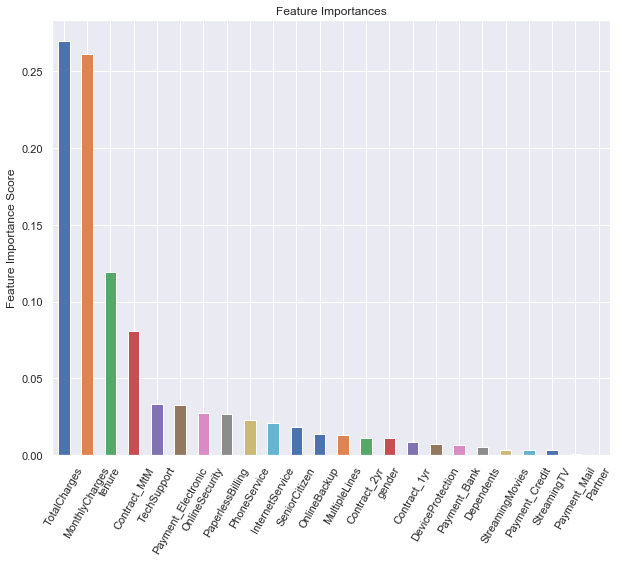

In [8]:
model = GradientBoostingClassifier(random_state=42)

grid_classifier(model, train, target, feat_imp=True)

#### N_estimators

Seconds to fit: 14.51
Grid Scores: 

{'mean_fit_time': array([0.11152401, 0.15473399, 0.19850492, 0.27412548, 0.32384391,
       0.34566593, 0.46308327, 0.46609459, 0.51363492, 0.54131255,
       0.55716186, 0.78116307, 0.87401366, 0.79621477, 0.72254281,
       0.75776572, 0.83319569, 0.91378951, 0.86040363]),
 'mean_score_time': array([0.0040659 , 0.00244899, 0.00254445, 0.00296087, 0.00841436,
       0.00307894, 0.0068656 , 0.00369716, 0.00453753, 0.00400472,
       0.00425224, 0.00671611, 0.00701561, 0.00731373, 0.00401258,
       0.0045589 , 0.00433431, 0.00489364, 0.00519223]),
 'mean_test_score': array([0.83321919, 0.83831329, 0.84142705, 0.84364714, 0.84449051,
       0.84544498, 0.84580454, 0.84605969, 0.84615437, 0.84593024,
       0.8455212 , 0.84542723, 0.84533161, 0.84520319, 0.84515021,
       0.84500487, 0.84472363, 0.84462893, 0.84468386]),
 'mean_train_score': array([0.84222507, 0.84870448, 0.85267935, 0.85654636, 0.85912974,
       0.8612237 , 0.86319185, 0.8649906 , 

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(10, 101, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

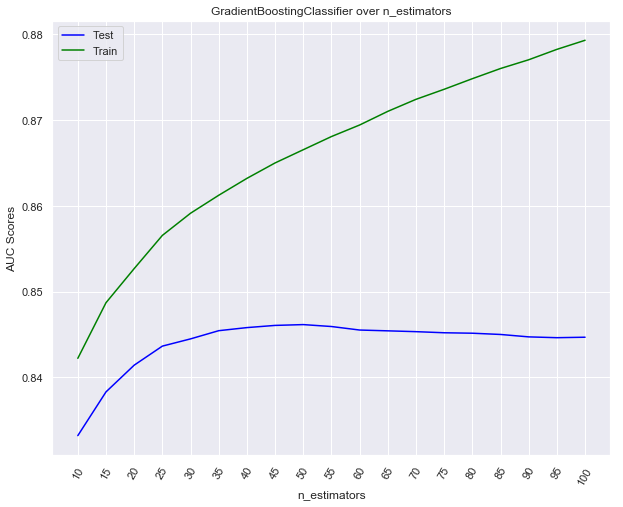

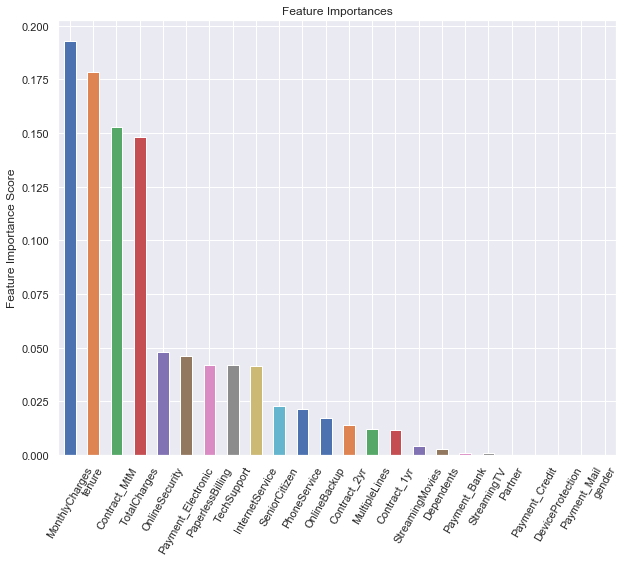

In [9]:
model = GradientBoostingClassifier(random_state=42)

parameters = {'n_estimators': range(10, 101, 5)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max Depth
Leaving this alone, looks like an overfit

Seconds to fit: 17.56
Grid Scores: 

{'mean_fit_time': array([0.56228452, 0.76476569, 1.04625177, 1.44514174, 2.09391227,
       2.88057199, 3.5919477 ]),
 'mean_score_time': array([0.00784402, 0.00420403, 0.00500197, 0.00585179, 0.00606842,
       0.00624895, 0.00622039]),
 'mean_test_score': array([0.84615437, 0.84390543, 0.8417994 , 0.83858761, 0.83304564,
       0.82820176, 0.8235545 ]),
 'mean_train_score': array([0.86652977, 0.88419333, 0.90959449, 0.93946462, 0.96756668,
       0.98733591, 0.99703871]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max_depth': 8},
            {'max_depth': 9}],
 'rank_test_score': array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 'split0_test_score': array([0

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

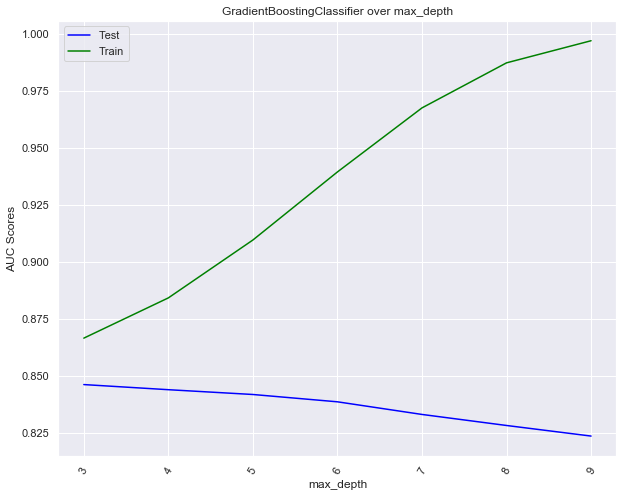

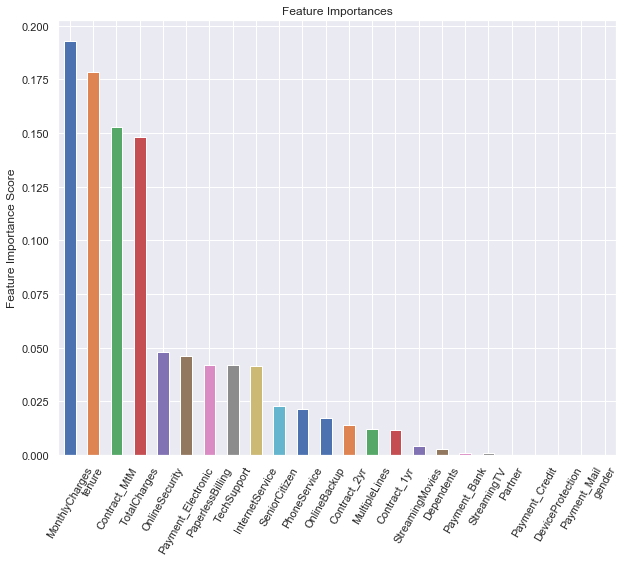

In [10]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50
)

parameters = {'max_depth': range(3, 10)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Min Samples Split
Leaving this alone as well

Seconds to fit: 9.88
Grid Scores: 

{'mean_fit_time': array([0.61445913, 0.65545793, 0.76254416, 0.56758304, 0.78437824,
       0.64564352, 0.64771814, 0.77768922, 0.5125165 , 0.69672418]),
 'mean_score_time': array([0.00957675, 0.00574598, 0.00467606, 0.0047143 , 0.00389709,
       0.00543222, 0.00539999, 0.00463533, 0.0042028 , 0.00411663]),
 'mean_test_score': array([0.84624773, 0.84627846, 0.84627458, 0.84615752, 0.84604305,
       0.846057  , 0.846057  , 0.846057  , 0.84599136, 0.84588438]),
 'mean_train_score': array([0.86630973, 0.86623355, 0.86617209, 0.86607065, 0.86609818,
       0.86622651, 0.86622651, 0.86615605, 0.86613471, 0.8660911 ]),
 'param_min_samples_split': masked_array(data=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_samples_split': 10},
            {'min_samples_split': 20},
            {'m

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': range(10, 101, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

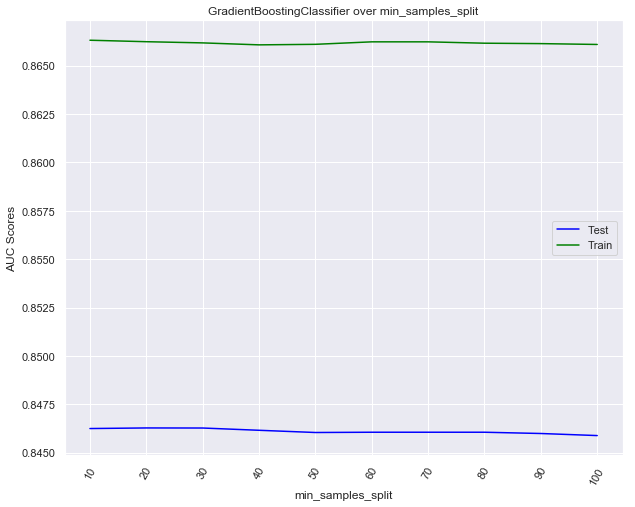

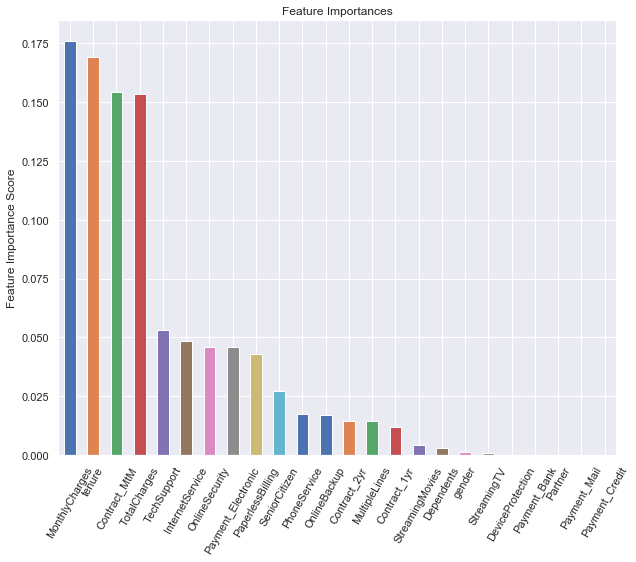

In [11]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50
)

parameters = {'min_samples_split': range(10, 101, 10)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Min Samples Leaf

Seconds to fit: 8.75
Grid Scores: 

{'mean_fit_time': array([0.47650185, 0.49391141, 0.50377121, 0.54573612, 0.86219497,
       0.85965142, 0.81310921, 0.55284438, 0.48301578, 0.41452961]),
 'mean_score_time': array([0.00476842, 0.00453   , 0.00484476, 0.00526643, 0.01242585,
       0.00491786, 0.00666294, 0.00417304, 0.00470581, 0.00355468]),
 'mean_test_score': array([0.84656129, 0.84679936, 0.84647329, 0.84650523, 0.84657374,
       0.84663017, 0.84662793, 0.84674576, 0.84685442, 0.84728421]),
 'mean_train_score': array([0.86604826, 0.86578113, 0.86557149, 0.86546468, 0.86537905,
       0.86533156, 0.8649416 , 0.8651369 , 0.86490813, 0.8648345 ]),
 'param_min_samples_leaf': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_samples_leaf': 5},
            {'min_samples_leaf': 10},
            {'min_sam

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': range(5, 51, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

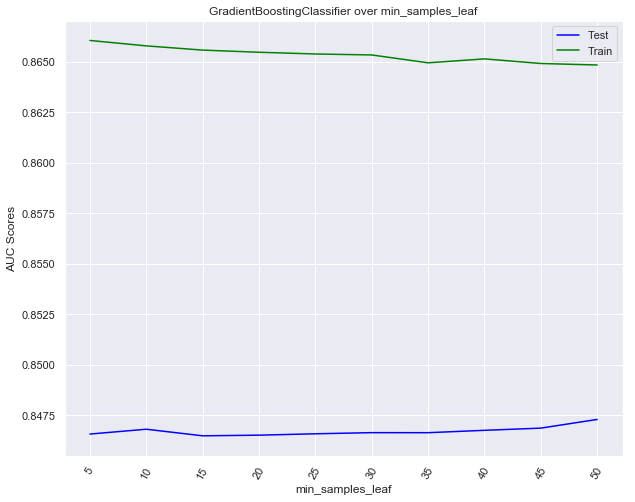

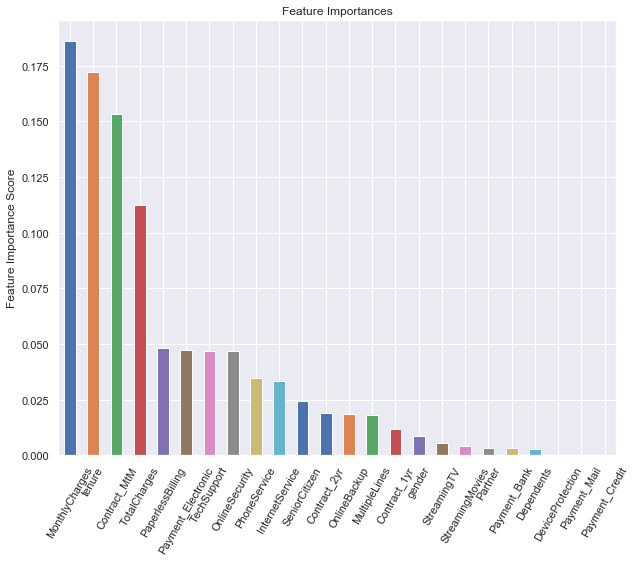

In [12]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50
)

parameters = {'min_samples_leaf': range(5, 51, 5)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max Features

Seconds to fit: 2.43
Grid Scores: 

{'mean_fit_time': array([0.19644103, 0.22476344, 0.21478419, 0.23663859, 0.24393539,
       0.23933296]),
 'mean_score_time': array([0.00492086, 0.005442  , 0.00308366, 0.00373206, 0.00453978,
       0.00348277]),
 'mean_test_score': array([0.84716905, 0.84609913, 0.84679225, 0.84729583, 0.84871095,
       0.84795251]),
 'mean_train_score': array([0.86037274, 0.86082579, 0.8609495 , 0.86273296, 0.86315867,
       0.86345482]),
 'param_max_features': masked_array(data=[4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_features': 4},
            {'max_features': 5},
            {'max_features': 6},
            {'max_features': 7},
            {'max_features': 8},
            {'max_features': 9}],
 'rank_test_score': array([4, 6, 5, 3, 1, 2], dtype=int32),
 'split0_test_score': array([0.86075977, 0.85813118, 0.85992017, 0.86077269, 0.86006872,
       0.860

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(4, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

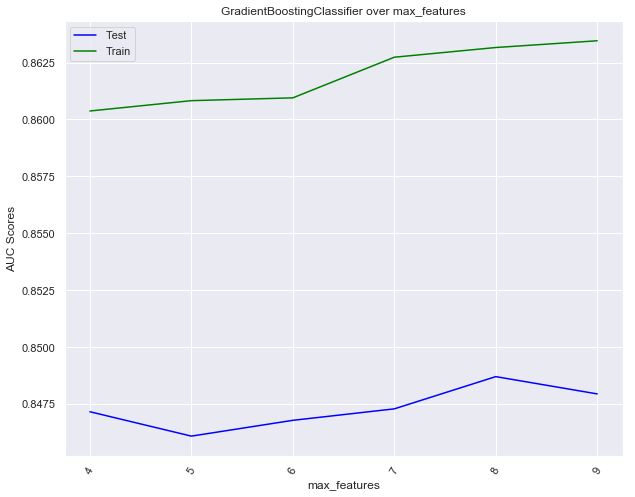

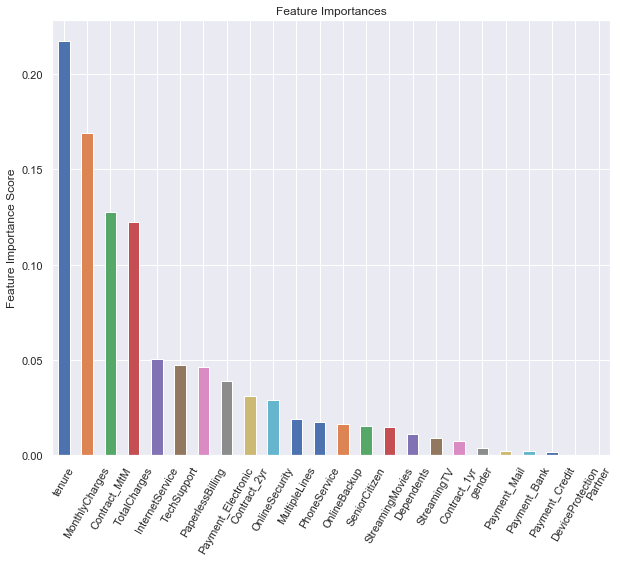

In [13]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    min_samples_leaf=10,
)

parameters = {'max_features': range(4, 10)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Learning Rate
Increase and decrease the learning rate in proportion to the trees. 

Results:

| factor | trees | rate | AUC    |
|--------|-------|------|--------|
| 2/3    | 33    | 1.5  | 0.8474 |
| 1      | 50    | 0.1  | 0.8487 |
| 1.5    | 75    | 0.67 | 0.8481 |
| 2      | 100   | 0.5  | 0.8477 |
| 4      | 200   | 0.25 | 0.8477 |

So it looks like the learning rate didn't need tuning, sticking with default of 0.1

In [14]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=int(50/1.5),
    min_samples_leaf=10,
    max_features=8,
    learning_rate=(0.1*1.5)
)

grid_classifier(model, train, target)

Seconds to fit: 0.65
Grid Scores: 

{'mean_fit_time': array([0.15815129]),
 'mean_score_time': array([0.0044497]),
 'mean_test_score': array([0.84739696]),
 'mean_train_score': array([0.8623024]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85924204]),
 'split0_train_score': array([0.85937105]),
 'split1_test_score': array([0.85591077]),
 'split1_train_score': array([0.85982501]),
 'split2_test_score': array([0.83328037]),
 'split2_train_score': array([0.86681376]),
 'split3_test_score': array([0.84427911]),
 'split3_train_score': array([0.86294017]),
 'split4_test_score': array([0.84426808]),
 'split4_train_score': array([0.862562]),
 'std_fit_time': array([0.02394109]),
 'std_score_time': array([0.0018136]),
 'std_test_score': array([0.00929181]),
 'std_train_score': array([0.00266671])}
Best Model Parameters: {}
Best Model Score: 0.8474


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15000000000000002, loss='deviance',
              max_depth=3, max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=33,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [15]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=0.1
)

grid_classifier(model, train, target)

Seconds to fit: 0.81
Grid Scores: 

{'mean_fit_time': array([0.22827091]),
 'mean_score_time': array([0.0040916]),
 'mean_test_score': array([0.84871095]),
 'mean_train_score': array([0.86315867]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86006872]),
 'split0_train_score': array([0.86005611]),
 'split1_test_score': array([0.85762484]),
 'split1_train_score': array([0.86091692]),
 'split2_test_score': array([0.83401535]),
 'split2_train_score': array([0.86793362]),
 'split3_test_score': array([0.84531633]),
 'split3_train_score': array([0.86337029]),
 'split4_test_score': array([0.84652641]),
 'split4_train_score': array([0.8635164]),
 'std_fit_time': array([0.04219345]),
 'std_score_time': array([0.00083318]),
 'std_test_score': array([0.00938969]),
 'std_train_score': array([0.00274315])}
Best Model Parameters: {}
Best Model Score: 0.8487


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [16]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=75,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=(0.1/1.5)
)

grid_classifier(model, train, target)

Seconds to fit: 1.19
Grid Scores: 

{'mean_fit_time': array([0.38440013]),
 'mean_score_time': array([0.00813098]),
 'mean_test_score': array([0.84805992]),
 'mean_train_score': array([0.86338863]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85976905]),
 'split0_train_score': array([0.86035913]),
 'split1_test_score': array([0.85678912]),
 'split1_train_score': array([0.86134405]),
 'split2_test_score': array([0.83404635]),
 'split2_train_score': array([0.86781476]),
 'split3_test_score': array([0.84337105]),
 'split3_train_score': array([0.86390053]),
 'split4_test_score': array([0.84632158]),
 'split4_train_score': array([0.86352471]),
 'std_fit_time': array([0.03568611]),
 'std_score_time': array([0.00299168]),
 'std_test_score': array([0.00932533]),
 'std_train_score': array([0.00257796])}
Best Model Parameters: {}
Best Model Score: 0.8481


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.06666666666666667, loss='deviance',
              max_depth=3, max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=75,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [17]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=100,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=0.05
)

grid_classifier(model, train, target)

Seconds to fit: 1.49
Grid Scores: 

{'mean_fit_time': array([0.5056736]),
 'mean_score_time': array([0.01300383]),
 'mean_test_score': array([0.84773061]),
 'mean_train_score': array([0.86329907]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85954558]),
 'split0_train_score': array([0.86054182]),
 'split1_test_score': array([0.85583069]),
 'split1_train_score': array([0.86096136]),
 'split2_test_score': array([0.8335723]),
 'split2_train_score': array([0.86747934]),
 'split3_test_score': array([0.84243716]),
 'split3_train_score': array([0.86415013]),
 'split4_test_score': array([0.84726666]),
 'split4_train_score': array([0.86336269]),
 'std_fit_time': array([0.06880723]),
 'std_score_time': array([0.01176958]),
 'std_test_score': array([0.00931688]),
 'std_train_score': array([0.00250081])}
Best Model Parameters: {}
Best Model Score: 0.8477


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [18]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=200,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=0.025
)

grid_classifier(model, train, target)

Seconds to fit: 2.61
Grid Scores: 

{'mean_fit_time': array([0.99422383]),
 'mean_score_time': array([0.01281734]),
 'mean_test_score': array([0.84768962]),
 'mean_train_score': array([0.86363468]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85959338]),
 'split0_train_score': array([0.8611982]),
 'split1_test_score': array([0.85633315]),
 'split1_train_score': array([0.86126155]),
 'split2_test_score': array([0.83303495]),
 'split2_train_score': array([0.86776442]),
 'split3_test_score': array([0.8425702]),
 'split3_train_score': array([0.8644946]),
 'split4_test_score': array([0.84691533]),
 'split4_train_score': array([0.86345464]),
 'std_fit_time': array([0.21016785]),
 'std_score_time': array([0.00638692]),
 'std_test_score': array([0.0095719]),
 'std_train_score': array([0.00242466])}
Best Model Parameters: {}
Best Model Score: 0.8477


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.025, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

#### Final Sklearn GBM Model

Seconds to fit: 0.92
Grid Scores: 

{'mean_fit_time': array([0.31433115]),
 'mean_score_time': array([0.00569844]),
 'mean_test_score': array([0.84871095]),
 'mean_train_score': array([0.86315867]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86006872]),
 'split0_train_score': array([0.86005611]),
 'split1_test_score': array([0.85762484]),
 'split1_train_score': array([0.86091692]),
 'split2_test_score': array([0.83401535]),
 'split2_train_score': array([0.86793362]),
 'split3_test_score': array([0.84531633]),
 'split3_train_score': array([0.86337029]),
 'split4_test_score': array([0.84652641]),
 'split4_train_score': array([0.8635164]),
 'std_fit_time': array([0.06410193]),
 'std_score_time': array([0.00254476]),
 'std_test_score': array([0.00938969]),
 'std_train_score': array([0.00274315])}
Best Model Parameters: {}
Best Model Score: 0.8487


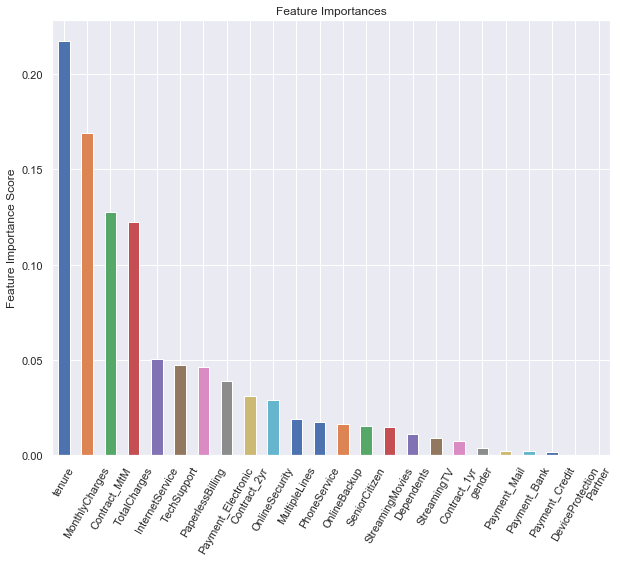

In [30]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=0.1
)

sgbm_gsearch = grid_classifier(model, train, target, feat_imp=True)

---
### XGBoost
#### Benchmark

Seconds to fit: 3.24
Grid Scores: 

{'mean_fit_time': array([1.26445436]),
 'mean_score_time': array([0.01235609]),
 'mean_test_score': array([0.84530086]),
 'mean_train_score': array([0.8743074]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85663282]),
 'split0_train_score': array([0.87193641]),
 'split1_test_score': array([0.85357927]),
 'split1_train_score': array([0.8727687]),
 'split2_test_score': array([0.82942597]),
 'split2_train_score': array([0.87871677]),
 'split3_test_score': array([0.84288279]),
 'split3_train_score': array([0.87455342]),
 'split4_test_score': array([0.84398157]),
 'split4_train_score': array([0.8735617]),
 'std_fit_time': array([0.22097956]),
 'std_score_time': array([0.00368736]),
 'std_test_score': array([0.00955691]),
 'std_train_score': array([0.00236847])}
Best Model Parameters: {}
Best Model Score: 0.8453


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

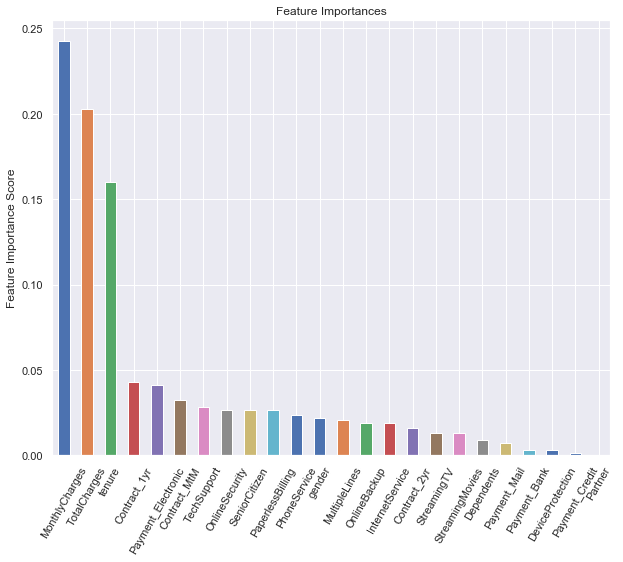

In [26]:
model = XGBClassifier(random_state=42)

grid_classifier(model, train, target, feat_imp=True)

#### N_estimators

Seconds to fit: 19.63
Grid Scores: 

{'mean_fit_time': array([0.14677467, 0.23266406, 0.29047403, 0.37905259, 0.41895504,
       0.49447446, 0.55029793, 0.61567636, 0.67631602, 0.75305777,
       0.80424137, 0.87057819, 0.93697777, 1.02471547, 1.06549697,
       1.15579753, 1.17189116, 1.27788358, 1.18318152]),
 'mean_score_time': array([0.00615516, 0.0045476 , 0.00717845, 0.00530658, 0.00503678,
       0.00448117, 0.00556064, 0.00617399, 0.00613818, 0.00700216,
       0.0068006 , 0.00641208, 0.00744944, 0.00825338, 0.0082922 ,
       0.00989542, 0.00937624, 0.01266093, 0.00768428]),
 'mean_test_score': array([0.83200397, 0.83642248, 0.83882232, 0.84174802, 0.84330084,
       0.84444866, 0.84549649, 0.8460322 , 0.84643704, 0.84654238,
       0.84662318, 0.84636647, 0.84633147, 0.8459801 , 0.84581021,
       0.84581042, 0.84579399, 0.84543479, 0.84530086]),
 'mean_train_score': array([0.84010688, 0.84561103, 0.84949363, 0.85298783, 0.85557229,
       0.85807415, 0.86000457, 0.86179908, 

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(10, 101, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

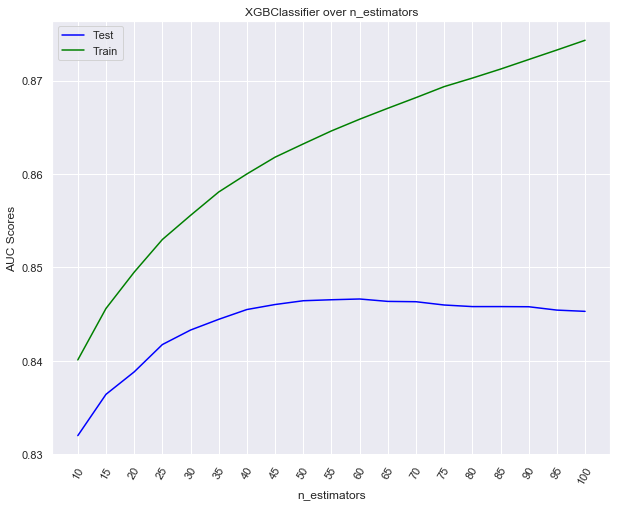

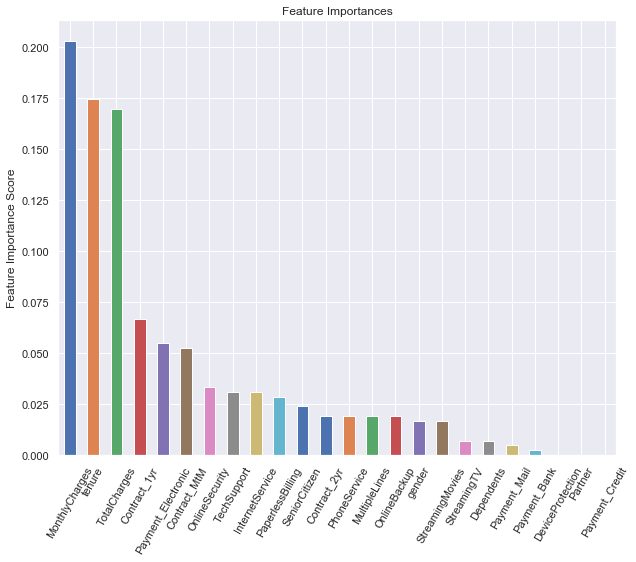

In [27]:
model = XGBClassifier(random_state=42)

parameters = {'n_estimators': range(10, 101, 5)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max Depth
Sticking with default value of 3

Seconds to fit: 15.39
Grid Scores: 

{'mean_fit_time': array([0.90874224, 1.26736312, 1.38625965, 1.80055604, 1.72745914,
       1.77380004, 1.86906338]),
 'mean_score_time': array([0.01050777, 0.01031799, 0.01151524, 0.01897798, 0.01100469,
       0.013446  , 0.0129395 ]),
 'mean_test_score': array([0.84662318, 0.845098  , 0.84222181, 0.83971788, 0.83551635,
       0.83206519, 0.8268007 ]),
 'mean_train_score': array([0.86585993, 0.88056003, 0.89955096, 0.92316852, 0.9463969 ,
       0.96574917, 0.9806189 ]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max_depth': 8},
            {'max_depth': 9}],
 'rank_test_score': array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 'split0_test_score': array([0

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

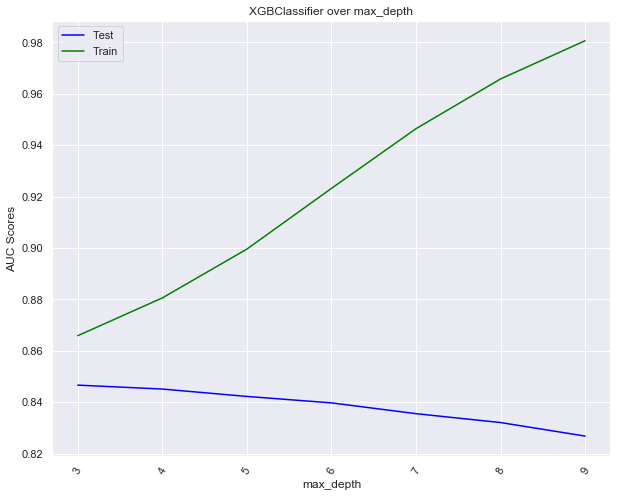

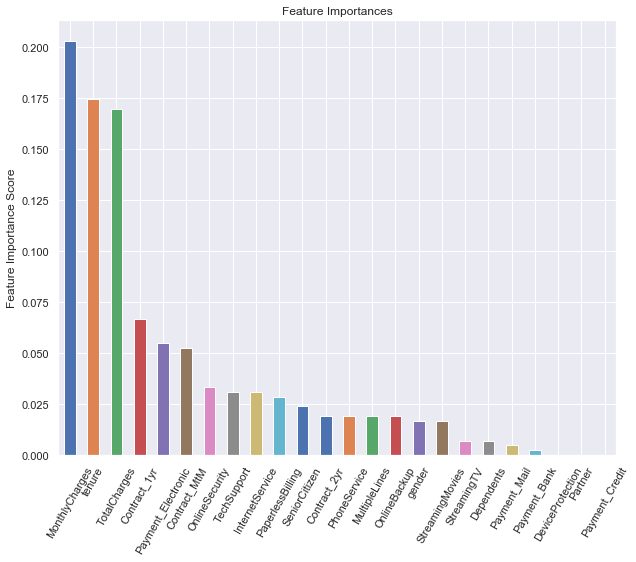

In [28]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60
)
    
parameters = {'max_depth': range(3, 10)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Min Child Weight

Seconds to fit: 10.73
Grid Scores: 

{'mean_fit_time': array([0.85323081, 1.04637599, 0.92422404, 0.90413499, 1.0740788 ,
       1.15542769, 1.09803753]),
 'mean_score_time': array([0.01099863, 0.01636467, 0.00905786, 0.00838056, 0.00951977,
       0.01547189, 0.01124163]),
 'mean_test_score': array([0.84662318, 0.84659287, 0.84673217, 0.84660996, 0.84669787,
       0.84698157, 0.84687824]),
 'mean_train_score': array([0.86585993, 0.86581051, 0.86573249, 0.86550589, 0.86561734,
       0.86575519, 0.86578379]),
 'param_min_child_weight': masked_array(data=[1, 2, 3, 4, 5, 6, 7],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_child_weight': 1},
            {'min_child_weight': 2},
            {'min_child_weight': 3},
            {'min_child_weight': 4},
            {'min_child_weight': 5},
            {'min_child_weight': 6},
            {'min_child_weight': 7}],
 'rank_test_score': array([5, 7, 3, 6

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': range(1, 8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

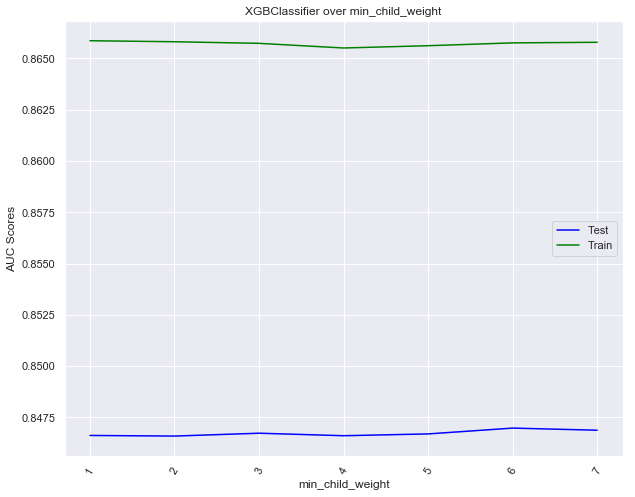

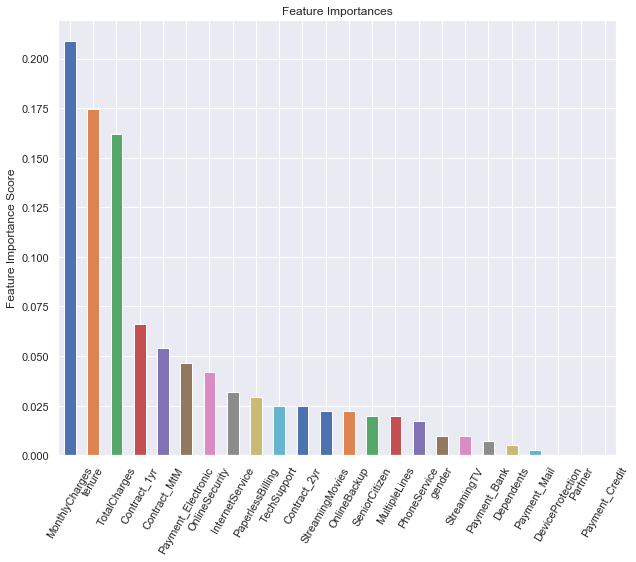

In [31]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60
)
    
parameters = {'min_child_weight': range(1, 8)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Subsample

Seconds to fit: 14.41
Grid Scores: 

{'mean_fit_time': array([0.93946781, 0.8655437 , 0.87276497, 0.90242624, 0.92285914,
       0.99837775, 0.95385852, 1.06952672, 0.96640139, 0.92463474,
       0.76565151]),
 'mean_score_time': array([0.00974283, 0.00678172, 0.0079299 , 0.01015825, 0.00984097,
       0.00784717, 0.00922823, 0.01036725, 0.00806141, 0.00816889,
       0.00480924]),
 'mean_test_score': array([0.84723528, 0.84718609, 0.84833208, 0.84601303, 0.8471884 ,
       0.84724005, 0.84764726, 0.84679413, 0.84759844, 0.84716375,
       0.84698157]),
 'mean_train_score': array([0.86485547, 0.86509811, 0.86532701, 0.86512196, 0.86563482,
       0.86568107, 0.86585726, 0.86594328, 0.86587992, 0.8658417 ,
       0.86575519]),
 'param_subsample': masked_array(data=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,
                   0.8500000000000001, 0.9, 0.95, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_val

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'subsample': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

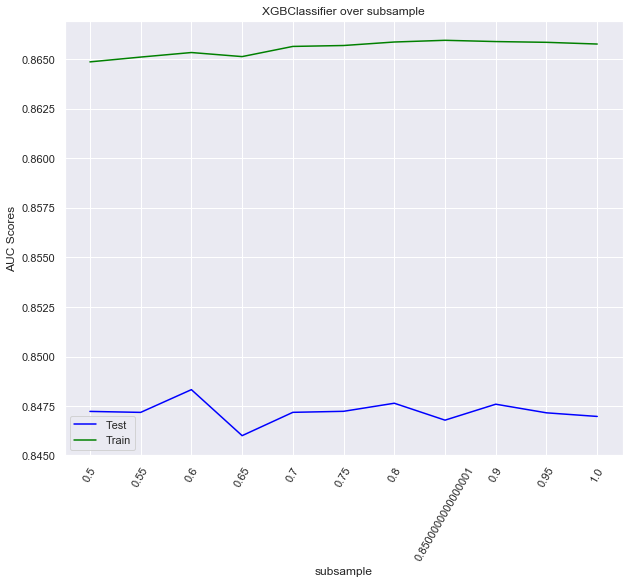

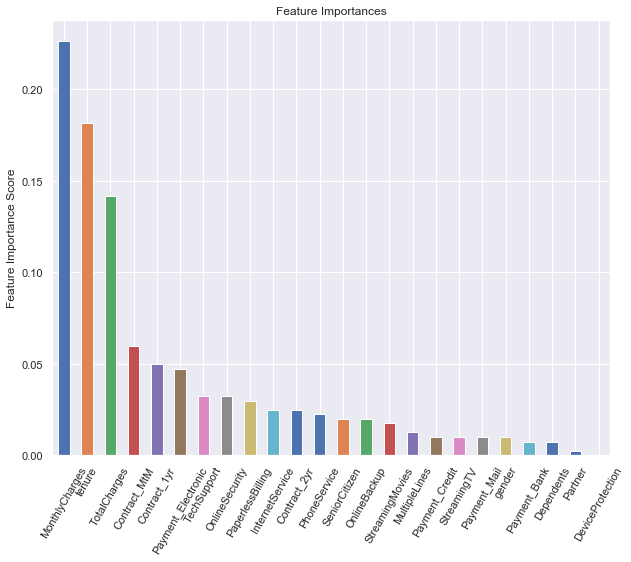

In [32]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60,
    min_child_weight=6
)
    
parameters = {'subsample': np.linspace(0.5, 1.0, 11)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Col Sample By Tree

Seconds to fit: 13.17
Grid Scores: 

{'mean_fit_time': array([0.60353694, 0.56094975, 0.63707328, 0.64971647, 0.65373697,
       0.65994716, 0.66955533, 0.70535536, 0.73915496, 0.81511617,
       0.85558701, 0.84609838, 0.77659698]),
 'mean_score_time': array([0.01100888, 0.00742664, 0.00685492, 0.00772467, 0.0062892 ,
       0.00829802, 0.00742064, 0.00923529, 0.00840721, 0.00928426,
       0.00785203, 0.00736799, 0.00690274]),
 'mean_test_score': array([0.84845157, 0.84788819, 0.8487639 , 0.84765816, 0.84774338,
       0.84780874, 0.84796569, 0.84809051, 0.84832745, 0.84832457,
       0.84795567, 0.84788475, 0.84833208]),
 'mean_train_score': array([0.86199166, 0.86264139, 0.86331294, 0.86354858, 0.86380828,
       0.86402203, 0.86416845, 0.86425905, 0.86446003, 0.8646387 ,
       0.86442538, 0.86462594, 0.86532701]),
 'param_colsample_bytree': masked_array(data=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,
                   0.8999999999999999, 0.95, 1.0],
             mas

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ,
       0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

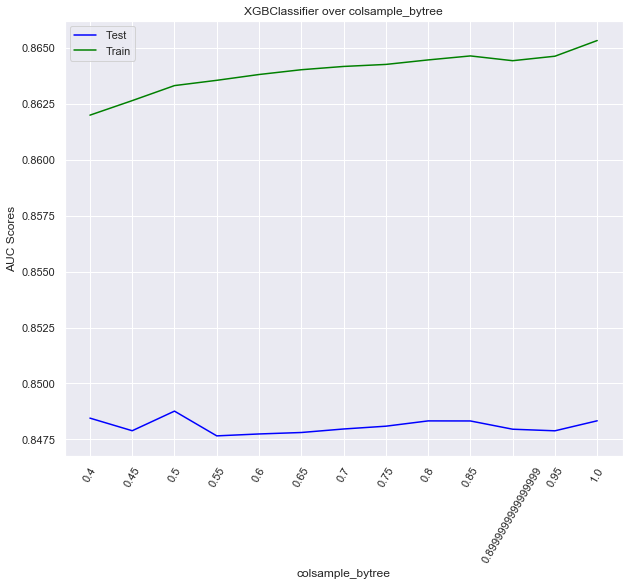

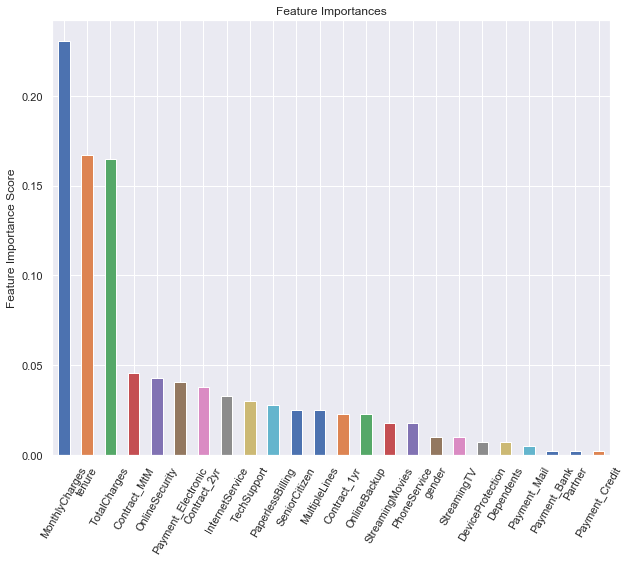

In [33]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60,
    min_child_weight=6,
    subsample=0.6
)
    
parameters = {'colsample_bytree': np.linspace(0.4, 1.0, 13)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Scale Pos Weight

Seconds to fit: 9.52
Grid Scores: 

{'mean_fit_time': array([0.45553875, 0.6156518 , 0.59784946, 0.60770168, 0.61046143,
       0.60227418, 0.61467438, 0.63449512, 0.62618432, 0.61899714,
       0.53408723]),
 'mean_score_time': array([0.01029401, 0.00633807, 0.00639696, 0.00702553, 0.00664711,
       0.00759134, 0.00871377, 0.00754843, 0.00720048, 0.00734162,
       0.00604177]),
 'mean_test_score': array([0.5       , 0.84647621, 0.84806553, 0.84821022, 0.84785283,
       0.84818471, 0.84850611, 0.84853285, 0.84844688, 0.84844474,
       0.8487639 ]),
 'mean_train_score': array([0.5       , 0.85438638, 0.8582757 , 0.85993942, 0.86094767,
       0.86169642, 0.86221992, 0.86265289, 0.8630065 , 0.86330502,
       0.86331294]),
 'param_scale_pos_weight': masked_array(data=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                   0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   Fals

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'scale_pos_weight': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

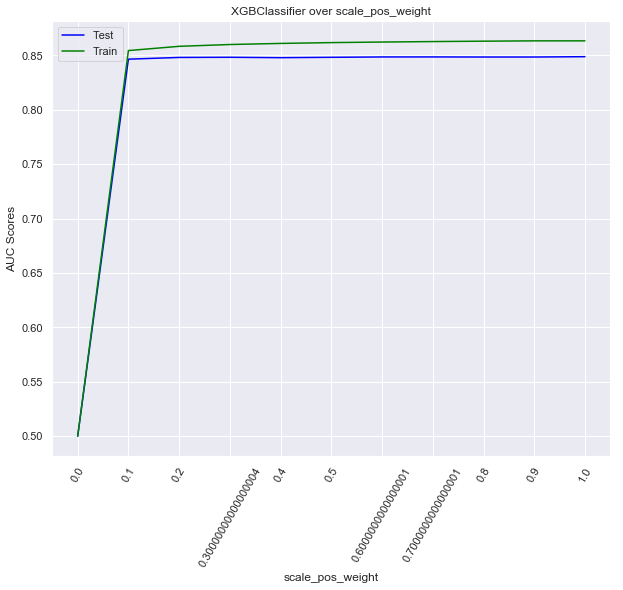

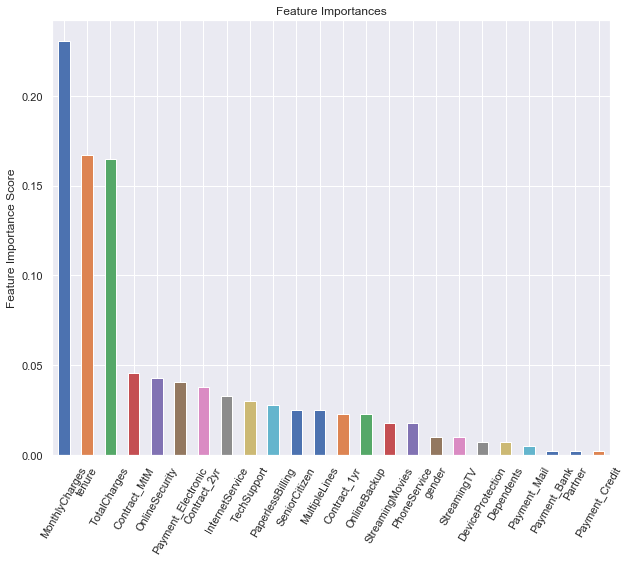

In [34]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60,
    min_child_weight=6,
    subsample=0.6,
    colsample_bytree=0.5
)
    
parameters = {'scale_pos_weight': np.arange(0.0, 1.1, 0.1)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Learning Rate
Increase and decrease the learning rate in proportion to the trees. 

Results:

| factor | trees | rate | AUC    |
|--------|-------|------|--------|
| 2/3    | 40    | 1.5  | 0.8467 |
| 1      | 60    | 0.1  | 0.8488 |
| 1.5    | 90    | 0.67 | 0.8488 |
| 2      | 120   | 0.5  | 0.8486 |
| 4      | 240   | 0.25 | 0.8489 |

Seconds to fit: 1.23
Grid Scores: 

{'mean_fit_time': array([0.38213134]),
 'mean_score_time': array([0.00932808]),
 'mean_test_score': array([0.84666221]),
 'mean_train_score': array([0.86327365]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85917616]),
 'split0_train_score': array([0.86017441]),
 'split1_test_score': array([0.85560981]),
 'split1_train_score': array([0.86040955]),
 'split2_test_score': array([0.83105738]),
 'split2_train_score': array([0.86864995]),
 'split3_test_score': array([0.84164535]),
 'split3_train_score': array([0.86362208]),
 'split4_test_score': array([0.84582117]),
 'split4_train_score': array([0.86351228]),
 'std_fit_time': array([0.06932114]),
 'std_score_time': array([0.00323436]),
 'std_test_score': array([0.01006169]),
 'std_train_score': array([0.0030624])}
Best Model Parameters: {}
Best Model Score: 0.8467


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=40,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

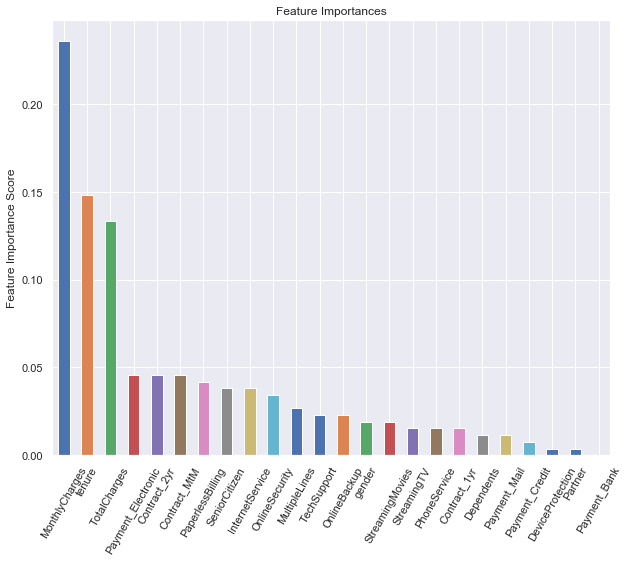

In [36]:
model = XGBClassifier(
    random_state=42,
    n_estimators=int(60/1.5),
    min_child_weight=6,
    subsample=0.6,
    colsample_bytree=0.5,
    learning_rate=0.15
)

grid_classifier(model, train, target, feat_imp=True)

Seconds to fit: 1.88
Grid Scores: 

{'mean_fit_time': array([0.73411994]),
 'mean_score_time': array([0.01035256]),
 'mean_test_score': array([0.8487639]),
 'mean_train_score': array([0.86331294]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86128678]),
 'split0_train_score': array([0.8602401]),
 'split1_test_score': array([0.85823452]),
 'split1_train_score': array([0.86058215]),
 'split2_test_score': array([0.83274432]),
 'split2_train_score': array([0.8675098]),
 'split3_test_score': array([0.84508512]),
 'split3_train_score': array([0.86411361]),
 'split4_test_score': array([0.84646548]),
 'split4_train_score': array([0.86411905]),
 'std_fit_time': array([0.18114096]),
 'std_score_time': array([0.00325209]),
 'std_test_score': array([0.0102186]),
 'std_train_score': array([0.00267597])}
Best Model Parameters: {}
Best Model Score: 0.8488


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

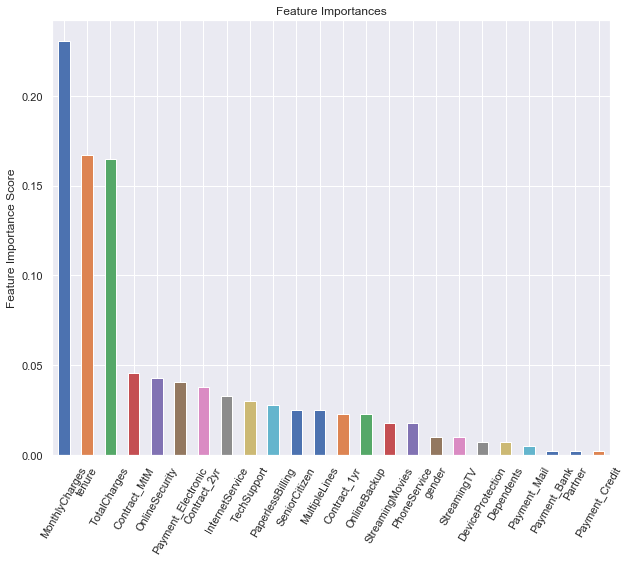

In [37]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60,
    min_child_weight=6,
    subsample=0.6,
    colsample_bytree=0.5,
    learning_rate=0.1
)

grid_classifier(model, train, target, feat_imp=True)

Seconds to fit: 2.30
Grid Scores: 

{'mean_fit_time': array([0.83237791]),
 'mean_score_time': array([0.00983129]),
 'mean_test_score': array([0.84877444]),
 'mean_train_score': array([0.86405445]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86184479]),
 'split0_train_score': array([0.86183218]),
 'split1_test_score': array([0.85800072]),
 'split1_train_score': array([0.86184035]),
 'split2_test_score': array([0.83302074]),
 'split2_train_score': array([0.8675923]),
 'split3_test_score': array([0.8446537]),
 'split3_train_score': array([0.8649993]),
 'split4_test_score': array([0.84634881]),
 'split4_train_score': array([0.86400813]),
 'std_fit_time': array([0.14453585]),
 'std_score_time': array([0.00245462]),
 'std_test_score': array([0.01026784]),
 'std_train_score': array([0.00215648])}
Best Model Parameters: {}
Best Model Score: 0.8488


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.06666666666666667,
       max_delta_step=0, max_depth=3, min_child_weight=6, missing=None,
       n_estimators=90, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

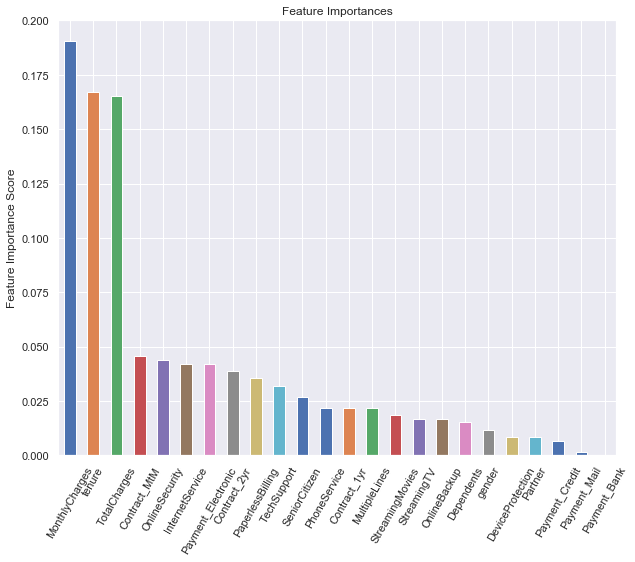

In [38]:
model = XGBClassifier(
    random_state=42,
    n_estimators=90,
    min_child_weight=6,
    subsample=0.6,
    colsample_bytree=0.5,
    learning_rate=(0.1/1.5)
)

grid_classifier(model, train, target, feat_imp=True)

Seconds to fit: 3.07
Grid Scores: 

{'mean_fit_time': array([1.16340618]),
 'mean_score_time': array([0.01459136]),
 'mean_test_score': array([0.84857156]),
 'mean_train_score': array([0.86383583]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86013589]),
 'split0_train_score': array([0.86133952]),
 'split1_test_score': array([0.85851998]),
 'split1_train_score': array([0.86173255]),
 'split2_test_score': array([0.83408251]),
 'split2_train_score': array([0.86757816]),
 'split3_test_score': array([0.84556563]),
 'split3_train_score': array([0.86462752]),
 'split4_test_score': array([0.8445481]),
 'split4_train_score': array([0.8639014]),
 'std_fit_time': array([0.23633931]),
 'std_score_time': array([0.00464826]),
 'std_test_score': array([0.00967441]),
 'std_train_score': array([0.00224906])}
Best Model Parameters: {}
Best Model Score: 0.8486


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=120,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

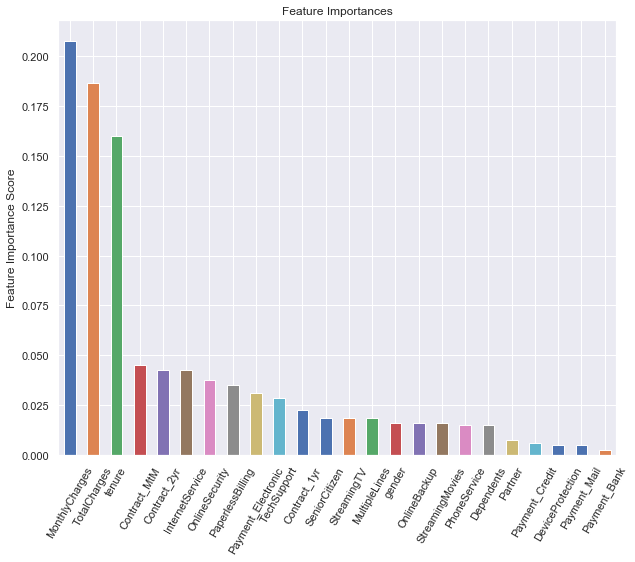

In [39]:
model = XGBClassifier(
    random_state=42,
    n_estimators=120,
    min_child_weight=6,
    subsample=0.6,
    colsample_bytree=0.5,
    learning_rate=0.05
)

grid_classifier(model, train, target, feat_imp=True)

Seconds to fit: 6.14
Grid Scores: 

{'mean_fit_time': array([2.49850373]),
 'mean_score_time': array([0.01986165]),
 'mean_test_score': array([0.84888071]),
 'mean_train_score': array([0.86416333]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86071327]),
 'split0_train_score': array([0.86157991]),
 'split1_test_score': array([0.85851869]),
 'split1_train_score': array([0.86179324]),
 'split2_test_score': array([0.83359296]),
 'split2_train_score': array([0.86831283]),
 'split3_test_score': array([0.84509029]),
 'split3_train_score': array([0.86461063]),
 'split4_test_score': array([0.84648493]),
 'split4_train_score': array([0.86452004]),
 'std_fit_time': array([0.57978718]),
 'std_score_time': array([0.0043923]),
 'std_test_score': array([0.00986765]),
 'std_train_score': array([0.00244283])}
Best Model Parameters: {}
Best Model Score: 0.8489


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.025,
       max_delta_step=0, max_depth=3, min_child_weight=6, missing=None,
       n_estimators=240, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

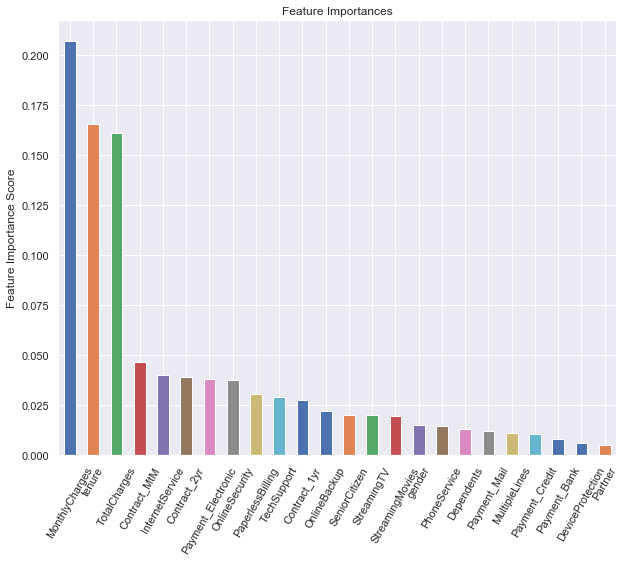

In [40]:
model = XGBClassifier(
    random_state=42,
    n_estimators=240,
    min_child_weight=6,
    subsample=0.6,
    colsample_bytree=0.5,
    learning_rate=0.025
)

grid_classifier(model, train, target, feat_imp=True)

#### Final XGBoost Model

Seconds to fit: 5.81
Grid Scores: 

{'mean_fit_time': array([2.20357862]),
 'mean_score_time': array([0.01754408]),
 'mean_test_score': array([0.84888071]),
 'mean_train_score': array([0.86416333]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86071327]),
 'split0_train_score': array([0.86157991]),
 'split1_test_score': array([0.85851869]),
 'split1_train_score': array([0.86179324]),
 'split2_test_score': array([0.83359296]),
 'split2_train_score': array([0.86831283]),
 'split3_test_score': array([0.84509029]),
 'split3_train_score': array([0.86461063]),
 'split4_test_score': array([0.84648493]),
 'split4_train_score': array([0.86452004]),
 'std_fit_time': array([0.42759275]),
 'std_score_time': array([0.00331725]),
 'std_test_score': array([0.00986765]),
 'std_train_score': array([0.00244283])}
Best Model Parameters: {}
Best Model Score: 0.8489


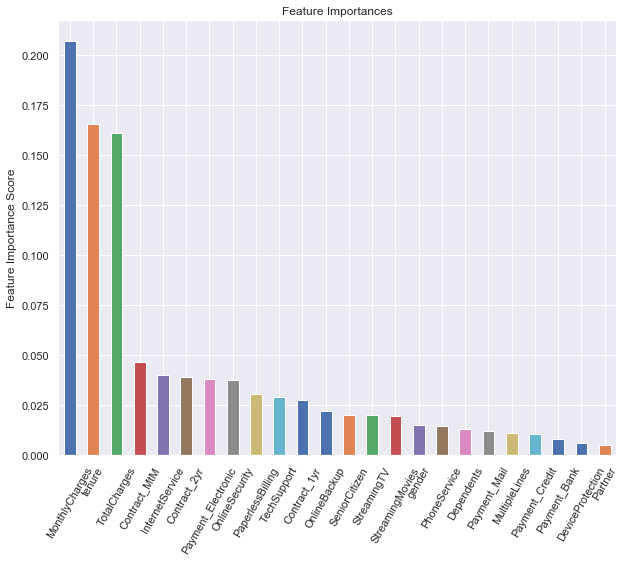

In [44]:
model = XGBClassifier(
    random_state=42,
    n_estimators=240,
    min_child_weight=6,
    subsample=0.6,
    colsample_bytree=0.5,
    learning_rate=0.025
)

xgb_gsearch = grid_classifier(model, train, target, feat_imp=True)